In [1]:
import os

os.environ["HF_ENDPOINT"] = "https://hf-mirror.com"
os.environ["HF_HUB_OFFLINE"] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "2,3"


In [2]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from torchinfo import summary
from PIL import Image, ImageDraw, ImageFont

from copy import deepcopy, copy
from tqdm.auto import tqdm
from matplotlib import pyplot as plt
%matplotlib widget

from transformers import (
    AutoModelForImageTextToText,
    AutoTokenizer,
    AutoProcessor,
    Qwen2VLForConditionalGeneration,
    Qwen2VLProcessor,
    Qwen2VLConfig,
)
from transformers.generation.utils import (
    GenerateDecoderOnlyOutput,
)
from transformers.cache_utils import (
    DynamicCache,
    StaticCache,
    SinkCache,
    SlidingWindowCache,
    OffloadedCache,
    OffloadedStaticCache,

    Cache,
    CacheConfig,
)

from utils import cprint, make_layer_attn_hooks


In [3]:
from qwen import Qwen2VLForAttnExtraction, bbox_from_att_image_adaptive

small_model = Qwen2VLForAttnExtraction()


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [4]:
small_model = small_model.to("cuda:1")


In [5]:
QWEN_2_VL_2B_MODEL_ID = "Qwen/Qwen2-VL-2B-Instruct"
QWEN_2_VL_7B_MODEL_ID = "Qwen/Qwen2-VL-7B-Instruct"

model: Qwen2VLForConditionalGeneration = Qwen2VLForConditionalGeneration.from_pretrained(
    QWEN_2_VL_7B_MODEL_ID,
    torch_dtype="auto",
    local_files_only=True,
    use_safetensors=True,
    low_cpu_mem_usage=True,
) # type: ignore
processor: Qwen2VLProcessor = Qwen2VLProcessor.from_pretrained(
    QWEN_2_VL_7B_MODEL_ID, local_files_only=True, use_fast=True
) # type: ignore
assert isinstance(model, Qwen2VLForConditionalGeneration), model
assert isinstance(processor, Qwen2VLProcessor), processor


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

In [6]:
model = model.to("cuda")


In [7]:
# attn_out = {}
# make_layer_attn_hooks(
#     model.model.layers, [14, 15], attn_out, clear_hooks=True, clear_attn_output=True
# )


In [8]:
# summary(model, (1, 1), device="cuda", dtypes=[torch.long], depth=5)


## Inputs


In [9]:
image = Image.open("img4.png")


In [10]:
message = [
    {
        "role": "user",
        "content": [
            {"type": "image", "path": "img4.png"},
            {"type": "text", "text": "How many yellow objects are there in the image? Answer in one word."},
        ],
    }
]

text_prompt = processor.apply_chat_template(
    message, tokenize=False, add_generation_prompt=True
)

cprint(text_prompt)


<|im_start|>system\nYou are a helpful assistant.<|im_end|>\n<|im_start|>user\n<|vision_start|><|image_pad|><|vision_end|>How many yellow objects are there in the image? Answer in one word.<|im_end|>\n<|im_start|>assistant\n


In [11]:
inputs = processor(
    images=[image],
    text=text_prompt[:-1],
    return_tensors="pt",
    # padding=True,
)

print(inputs.keys())
print(f'input_ids: {inputs.input_ids.shape}')
print(f'attention_mask: {inputs.attention_mask.shape}')
print(f'pixel_values: {inputs.pixel_values.shape}')
print(f'image_grid_thw: {inputs.image_grid_thw.tolist()}')

inputs = inputs.to(model.device)


dict_keys(['input_ids', 'attention_mask', 'pixel_values', 'image_grid_thw'])
input_ids: torch.Size([1, 156])
attention_mask: torch.Size([1, 156])
pixel_values: torch.Size([484, 1176])
image_grid_thw: [[1, 22, 22]]


## Attention Extraction

In [12]:
attn = small_model.extract_attention(
    "Where's the yellow object in the image?",
    image,
    # [],
    attn_type="contrastive",
    single_token_generation=False,
    contrast_layers=(14, 6),
)
attn[0].shape


Qwen2VLModel is using Qwen2VLSdpaAttention, but `torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


torch.Size([11, 11])

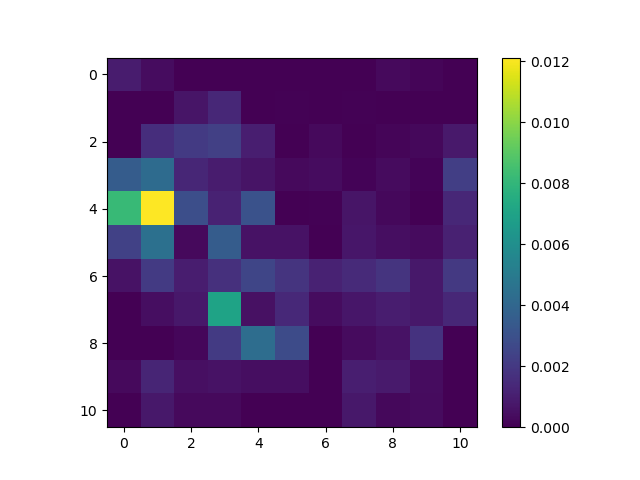

In [13]:
plt.imshow(attn[0][:, :])
plt.colorbar()
plt.show()



## Stream Test

[Iterative Generation](https://huggingface.co/docs/transformers/main/en/kv_cache#iterative-generation)

In [14]:
# model.generate(streamer=None)


## Cache Test

[Cache Prefilling](https://huggingface.co/docs/transformers/main/en/kv_cache#prefill-a-cache)

In [15]:
prompt_cache = StaticCache(
    config=model.config,
    max_batch_size=1,
    max_cache_len=512,
    device=model.device,
    dtype=model.dtype,
    # layer_device_map={0: "cuda", 1: "cuda", 2: "cuda", 3: "cuda", 4: "cuda", 5: "cuda", 6: "cuda", 7: "cuda"}
)


In [16]:
with torch.no_grad():
    # prompt_cache.reset()
    prompt_cache = DynamicCache()
    initial_outputs = model(**inputs, past_key_values=prompt_cache)
    prompt_cache = initial_outputs.past_key_values

print(f"prompt_len: {prompt_cache.get_seq_length()}")


prompt_len: 156


In [17]:
initial_outputs.keys()

print(initial_outputs.logits.shape)
# print(initial_outputs.past_key_values)
print(initial_outputs.rope_deltas)


torch.Size([1, 156, 152064])
tensor([[-110]], device='cuda:0')


In [18]:
new_inputs = processor(
    images=[image],
    text=text_prompt,
    return_tensors="pt",
    # padding=True,
)
new_inputs = new_inputs.to(model.device)


In [19]:
# processor.decode(initial_outputs.logits[0, -1, :].argmax(dim=-1))
# new_tokens = initial_outputs.logits[0, -1, :].argmax(dim=-1)
# new_texts = processor.decode(new_tokens)

# dict(prompt_cache.named_buffers()).keys()


In [20]:
# new_inputs = processor(
#     images=[image],
#     text=text_prompt,# + new_texts,
#     return_tensors="pt",
#     # padding=True,
# ).to(model.device)
# new_inputs


In [21]:
from typing import Literal

# Apply weighted attention to vision tokens, fix multiple images
def reweighted_vision_tokens(
    vision_attn_weight,
    keep_percentage,
    weighting_type: Literal["linear", "uniform", "suppress"] = "linear",
    lowest_weight=0.0,
    neg_attn_weight=None,
    suppress_alpha=0.5,
):
    if weighting_type == "suppress":
        if neg_attn_weight is None:
            raise ValueError("neg_attn_weight must be provided for suppress mode")
        # 使用负样例注意力权重进行抑制
        weight_vision_token = 1 - suppress_alpha * neg_attn_weight
        return weight_vision_token

    sorted_indices = torch.argsort(vision_attn_weight, descending=True)
    num_tokens_to_keep = int(len(vision_attn_weight) * keep_percentage)
    weight_vision_token = torch.zeros_like(vision_attn_weight, dtype=torch.float)
    weight_vision_token[sorted_indices[:num_tokens_to_keep]] = 1.0
    if weighting_type == "linear":
        weight_vision_token[sorted_indices[num_tokens_to_keep:]] = torch.linspace(
            lowest_weight, 1.0, len(vision_attn_weight) - num_tokens_to_keep
        )
    else:
        weight_vision_token[sorted_indices[num_tokens_to_keep:]] = lowest_weight
    return weight_vision_token


In [22]:
attn_flat = attn[0].flatten()

weight = reweighted_vision_tokens(
    attn_flat, keep_percentage=0.5, lowest_weight=0.5, weighting_type="linear"
)
weight = weight.to(model.device)


In [23]:
vision_start_token_id = model.config.vision_start_token_id
vision_end_token_id = model.config.vision_end_token_id
prefill_len = inputs["input_ids"].shape[1]
vision_start_token_indices = (
    torch.where(inputs["input_ids"][0] == vision_start_token_id)[0] + 1
)
vision_end_token_indices = torch.where(inputs["input_ids"][0] == vision_end_token_id)[0]
assert len(vision_start_token_indices) == len(vision_end_token_indices) == 1, (
    "vision_start_token_indices and vision_end_token_indices should have the same length"
)


In [24]:
vision_end_token_indices - vision_start_token_indices


tensor([121], device='cuda:0')

In [25]:
# dict(prompt_cache.named_buffers()).keys()

# Each layer of key_cache should have a size (bs, n_head_groups, n_max_cache_len, d_head)
# As Qwen 2+ invoke GQA with group_size = 6, so n_head_groups = 2, while n_head = 12

# for name, buffer in prompt_cache.named_buffers():
#   if name.startswith('key_cache_'):
#     print(f'{name}: {buffer.shape}')

for i, k in enumerate(prompt_cache.key_cache):
    # print(f'key layer {i:2d}: {tuple(k.shape)}')
    k[:, :, vision_start_token_indices:vision_end_token_indices, :] *= weight[None, None, :, None]
    
    


In [26]:
new_outputs = model.generate(**new_inputs, past_key_values=prompt_cache, max_new_tokens=512)


In [27]:
cprint(processor.decode(new_outputs[0]))


<|im_start|>system\nYou are a helpful assistant.<|im_end|>\n<|im_start|>user\n<|vision_start|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_p